# P5 - Notebook EDA

## Exercices :
- ### 1 - Importation des bibliothèques
- ### 2 - Importation et Traitment des Datasets 
- ### 3 - Definition de la base de données clients
- ### 4 - Analyse Exploratoire

# Importation des Bibliothèques et Mise en Forme :

In [2]:
# Installation des Bibliothèques :

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import os
import missingno as msno
import warnings
from functools import reduce

pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -100)

/var/folders/__/sl6gcy7s7r9d0cg0vj7xhw800000gn/T/ipykernel_1042/2692073543.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -100)


- ### Importation des données

In [15]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_order_items = pd.read_csv('olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_traductions = pd.read_csv('product_category_name_translation.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')

- ### Vue d'ensemble du jeu de données

In [16]:
jeu_de_donnees = [df_customers,
                  df_geolocation,
                  df_order_items,
                  df_order_payments,
                  df_order_reviews,
                  df_orders,
                  df_products,
                  df_sellers,
                  df_traductions]

df_noms = ['df_customers',
           'df_geolocation',
           'df_order_items',
           'df_order_payments',
           'df_order_reviews',
           'df_orders',
           'df_products',
           'df_sellers',
           'df_traductions']

vue_globale = pd.DataFrame({},)
vue_globale['Datasets'] = df_noms
vue_globale['nom de colonnes'] = [
    ', '.join([col for col in df.columns]) for df in jeu_de_donnees]
vue_globale['Nombre de lignes'] = [df.shape[0] for df in jeu_de_donnees]
vue_globale['Nombre de colonnes'] = [df.shape[1] for df in jeu_de_donnees]
vue_globale['Doublons'] = [df.duplicated().sum() for df in jeu_de_donnees]
vue_globale['NaN'] = [df.isnull().sum().sum() for df in jeu_de_donnees]
vue_globale.style.background_gradient(cmap='Blues')

,Datasets,nom de colonnes,Nombre de lignes,Nombre de colonnes,Doublons,NaN
0,df_customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0
1,df_geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0
2,df_order_items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0
3,df_order_payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0
4,df_order_reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903
5,df_orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441,8,0,4908
6,df_products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448
7,df_sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0
8,df_traductions,"product_category_name, product_category_name_english",71,2,0,0


- ### Verifier le nombre de dataset = 9

In [17]:
def controle_base_donnees(liste_des_donnees):
    if type(liste_des_donnees) is list:
        if len(liste_des_donnees) == 9:
            for df in liste_des_donnees:
                if type(df) is not type(pd.DataFrame()):
                    return False
        else:
            return False
    else:
        return False
    return True


print('Nombre de datasets verifié: ', controle_base_donnees(jeu_de_donnees))

Nombre de datasets verifié:  True


- ## Fonction de suppression des des outliers

In [18]:
from sklearn.neighbors import LocalOutlierFactor


def supp_outliers_univaries(dataframe):
 # exclusion du centile le plus extreme

    # valeurs extremes
    index_nan = []
    index_nan_flat = []
    for column in dataframe.select_dtypes(include=['int32', 'float64']).columns.tolist():

        index_nan.append(dataframe.loc[dataframe[column] > dataframe[
            column].quantile(0.99)].index.tolist())
        index_nan.append(dataframe.loc[dataframe[column] < dataframe[
            column].quantile(0.01)].index.tolist())

    for sublist in index_nan:
        for item in sublist:
            index_nan_flat.append(item)

    # suppression des doublons
    index_nan_flat = list(dict.fromkeys(index_nan_flat))
    dataframe[column].loc[index_nan_flat] = np.nan

    return dataframe.dropna(axis=0)


def supp_outliers_multivaries(dataframe):
    # Suppression des outliers multivariés

    lof = LocalOutlierFactor(n_neighbors=5, n_jobs=-1)
    lof.fit_predict(dataframe.select_dtypes(['float64', 'int32']).dropna())
    indices = dataframe.select_dtypes(['float64', 'int32']).dropna().index
    df_lof = pd.DataFrame(index=indices,
                          data=lof.negative_outlier_factor_, columns=['lof'])
    index_to_drop = df_lof[df_lof['lof'] < np.quantile(
        lof.negative_outlier_factor_, 0.01)].index
    return dataframe.drop(index_to_drop, axis=0)


def clean_dataset(dataframe):
    dataframe = supp_outliers_univaries(dataframe)

    dataframe = supp_outliers_multivaries(dataframe)
    return dataframe

- # Function pour retrouver la base de données

In [19]:
def create_aggregated_dataset(jeu_de_donnees):

    ###########################################################################
    # Assemblage des données
    ###########################################################################

    # customers_dataset.csv
    jeu_de_donnees[0] = jeu_de_donnees[0][['customer_id',
                                           'customer_unique_id', 'customer_city', 'customer_state']]

    # orders_item_dataset.csv
    jeu_de_donnees[2] = jeu_de_donnees[2][[
        'order_id', 'price', 'product_id', 'order_item_id']]

    # order_payments_dataset.csv
    jeu_de_donnees[3] = jeu_de_donnees[3][['order_id', 'payment_type', 'payment_value',
                                           'payment_installments', 'payment_sequential']]

    # order_reviews_dataset.csv
    jeu_de_donnees[4] = jeu_de_donnees[4][['order_id', 'review_score']]

    # orders_dataset.csv
    jeu_de_donnees[5] = jeu_de_donnees[5][['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
                                           'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date']]

    # product_dataset.csv
    jeu_de_donnees[6] = jeu_de_donnees[6][[
        'product_id', 'product_category_name']]

    # traduction_dataset.csv
    jeu_de_donnees[8] = jeu_de_donnees[8][[
        'product_category_name', 'product_category_name_english']]

    # Jointure des données par order_id
    merge_2_to_5_df = [jeu_de_donnees[2], jeu_de_donnees[3],
                       jeu_de_donnees[4], jeu_de_donnees[5]]

    df_merged1 = reduce(lambda left, right: pd.merge(left, right,
                                                     on='order_id', how='outer'), merge_2_to_5_df)

    # Jointure des données par product_category_name
    merge_6_and_8 = [jeu_de_donnees[6], jeu_de_donnees[8]]

    df_merged2 = reduce(lambda left, right: pd.merge(left, right,
                                                     on='product_category_name', how='outer'), merge_6_and_8)
    # Jointure des données par product_id
    df_merged3 = pd.merge(df_merged1, df_merged2, on='product_id', how='outer')

    # Jointure des données par customer_id
    df_merged = pd.merge(
        df_merged3, jeu_de_donnees[0], on='customer_id', how='outer')

    # Changement de format des dates

    datetime_columns = ['order_approved_at',
                        'order_delivered_customer_date', 'order_estimated_delivery_date']

    for var in datetime_columns:
        df_merged[var] = pd.to_datetime(
            df_merged[var], errors='coerce').dt.normalize()

    # Création d'une variable : temps de livraison
    df_merged['delivery_time'] = (
        df_merged['order_delivered_customer_date'] - df_merged['order_approved_at']).dt.days

    # @
    # Création du jeu de données agrégé par commande et client
    ################################################################################

    df_by_customer_and_order = df_merged[['customer_unique_id',
                                          'order_id',
                                          'price',
                                          'product_id',
                                          'order_item_id',
                                          'payment_type',
                                          'payment_value',
                                          'payment_installments',
                                          'payment_sequential',
                                          'review_score',
                                          'customer_id',
                                          'order_purchase_timestamp',
                                          'order_approved_at',
                                          'order_delivered_customer_date',
                                          'order_estimated_delivery_date',
                                          'product_category_name_english',
                                          'customer_city',
                                          'customer_state',
                                          'delivery_time']].groupby(['customer_unique_id', 'order_id'])\
        .agg({'delivery_time': 'mean',  # temps moyen de livraison
              'review_score': 'mean',  # note moyenne
              'price': 'mean',  # prix moyen de la commande
              'order_approved_at': 'min',  # Date de la commande
              'order_approved_at': 'max',
              'customer_state': 'max',  # Pays du client
              'product_id': 'count',
              'order_item_id': 'count',
              'payment_type': 'max',
              'payment_value': 'sum',
              'payment_installments': 'count'})  # nombre de produits par commande

    df_by_customer_and_order.reset_index(inplace=True)

    ############################################################################
    # Création du jeu de données agrégé par client
    ###########################################################################

    df_clients = df_by_customer_and_order.groupby('customer_unique_id')\
        .agg({'delivery_time': 'mean',  # temps moyen de livraison
              'review_score': 'mean',  # note moyenne
              'price': 'mean',  # prix moyen des commandes
              'order_approved_at': 'min',  # date de la 1ere commande
              'customer_state': 'max',
              'product_id': 'count',
              'payment_type': 'max',
              'payment_value': 'sum',
              'payment_installments': 'count',
              'order_id': 'count'}).round(2)  # Dépense totale

    # Renommage des colonnes
    df_clients.columns = ['mean_delivery_time',
                          'score_moyen_review',
                          'prix_moyen',
                          'date_premier_achat',
                          'customer_state',
                          'product_id',
                          'type_paiement',
                          'depenses_totales',
                          'payment_installments',
                          'nbr_achats'
                          ]

    # Date de la dernière commande
    df_clients['date_dernier_achat'] = df_by_customer_and_order.groupby(
        'customer_unique_id').agg({'order_approved_at': 'max'})

    #df_clients['order_approved_at'] = df_by_customer_and_order['order_approved_at']
    # Calcule de l'ancienneté (date du jour - date du premier achat)
    # df_clients['seniority'] = (
    # df_clients["last_order"].max() - df_clients['first_order']).dt.days

    # Récence (date du jour - date du dernier achat)
    df_clients['nb_jours_depuis_denier_achats'] = (
        df_clients["date_dernier_achat"].max() - df_clients['date_dernier_achat']).dt.days

    # Nombre moyen d'article par panier
    df_clients['nb_moy_articles'] = df_by_customer_and_order.groupby(
        'customer_unique_id').agg({'product_id': 'mean'}).round(2)

    df_clients.drop(['prix_moyen', 'product_id'], axis=1, inplace=True)

    # nettoyage des outliers
    print('Taille du jeu de données pré-nettoyage outliers : ', df_clients.shape)
    df_clients = clean_dataset(df_clients)
    print('Taille du jeu de données post-nettoyage outliers : ', df_clients.shape)

    return df_clients

In [20]:
df_clients = create_aggregated_dataset(jeu_de_donnees)


Taille du jeu de données pré-nettoyage outliers :  (96096, 11)


/var/folders/__/sl6gcy7s7r9d0cg0vj7xhw800000gn/T/ipykernel_1042/2484188642.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column].loc[index_nan_flat] = np.nan


Taille du jeu de données post-nettoyage outliers :  (87115, 11)


In [21]:
data_clients = df_clients.copy() 

In [22]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87115 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mean_delivery_time             87115 non-null  float64       
 1   score_moyen_review             87115 non-null  float64       
 2   date_premier_achat             87115 non-null  datetime64[ns]
 3   customer_state                 87115 non-null  object        
 4   type_paiement                  87115 non-null  object        
 5   depenses_totales               87115 non-null  float64       
 6   payment_installments           87115 non-null  int64         
 7   nbr_achats                     87115 non-null  int64         
 8   date_dernier_achat             87115 non-null  datetime64[ns]
 9   nb_jours_depuis_denier_achats  87115 non-null  float64       
 10  nb_moy_articles              

In [23]:
data_clients = data_clients[['nb_jours_depuis_denier_achats',
                             'nbr_achats',
                             'depenses_totales',
                             'date_premier_achat',
                             'date_dernier_achat',
                             'score_moyen_review',
                             'type_paiement',
                             'payment_installments',
                             'customer_state',
                             'mean_delivery_time',
                             'nb_moy_articles']]

In [24]:
data_clients.head(3)

,nb_jours_depuis_denier_achats,nbr_achats,depenses_totales,date_premier_achat,date_dernier_achat,score_moyen_review,type_paiement,payment_installments,customer_state,mean_delivery_time,nb_moy_articles
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116.0,1,141.90,2018-05-10,2018-05-10,5.0,credit_card,1,SP,6.0,1.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,27.19,2018-05-07,2018-05-07,4.0,credit_card,1,SP,3.0,1.0
0000f46a3911fa3c0805444483337064,542.0,1,86.22,2017-03-10,2017-03-10,3.0,credit_card,1,SC,26.0,1.0


- # Analyse Univariée

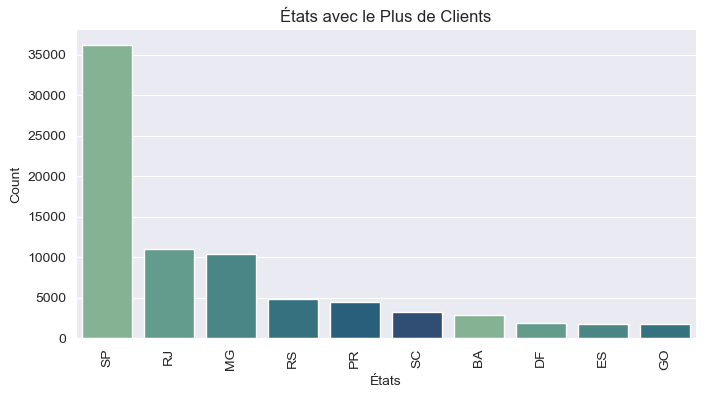

In [25]:
plt.figure(figsize=(8, 4))  # figure horizontale
palette = sns.color_palette('crest')  # palette de 10 couleurs différentes

sns.set_style("darkgrid")
sns.barplot(x=data_clients.customer_state.value_counts().iloc[:10].index,
            y=data_clients.customer_state.value_counts().iloc[:10],
            palette=palette)  # utilise la palette de couleurs définie
plt.xlabel("États")
plt.ylabel("Count")
plt.title("États avec le Plus de Clients")
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

sns.despine()  # enleve les bords superflus autour du graphique

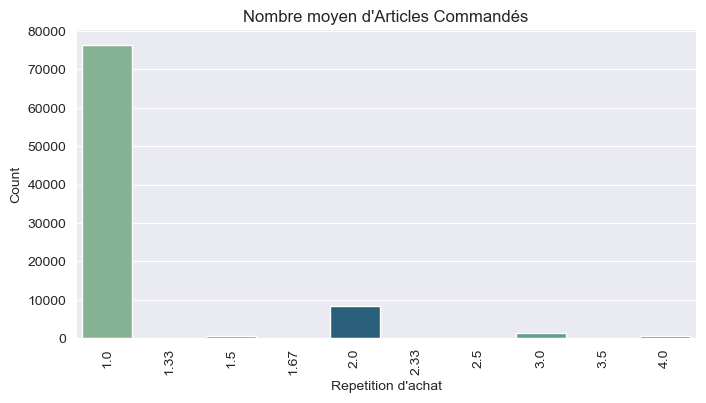

In [26]:
plt.figure(figsize=(8, 4))  # figure horizontale
palette = sns.color_palette('crest')  # palette de 10 couleurs différentes

sns.set_style("darkgrid")
sns.barplot(x=data_clients.nb_moy_articles.value_counts().iloc[:10].index,
            y=data_clients.nb_moy_articles.value_counts().iloc[:10],
            palette=palette)  # utilise la palette de couleurs définie
plt.xlabel("Repetition d'achat")
plt.ylabel("Count")
plt.title("Nombre moyen d'Articles Commandés")
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

sns.despine()  # enleve les bords superflus autour du graphique

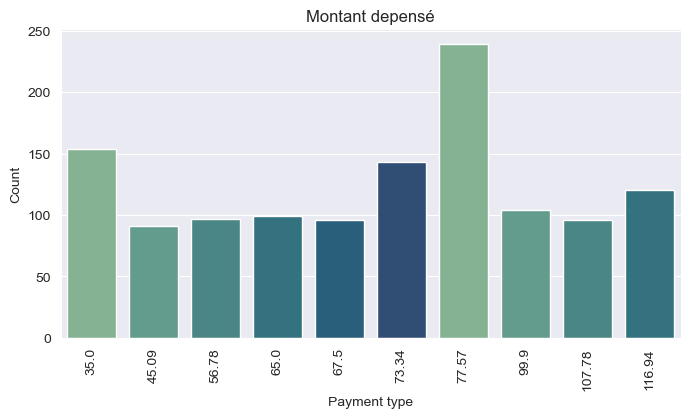

In [28]:
plt.figure(figsize=(8, 4))  # figure horizontale
palette = sns.color_palette('crest')  # palette de 10 couleurs différentes

sns.set_style("darkgrid")
sns.barplot(x=data_clients.depenses_totales.value_counts().iloc[:10].index,
            y=data_clients.depenses_totales.value_counts().iloc[:10],
            palette=palette)  # utilise la palette de couleurs définie
plt.xlabel("Payment type")
plt.ylabel("Count")
plt.title("Montant depensé")
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

sns.despine()  # enleve les bords superflus autour du graphique

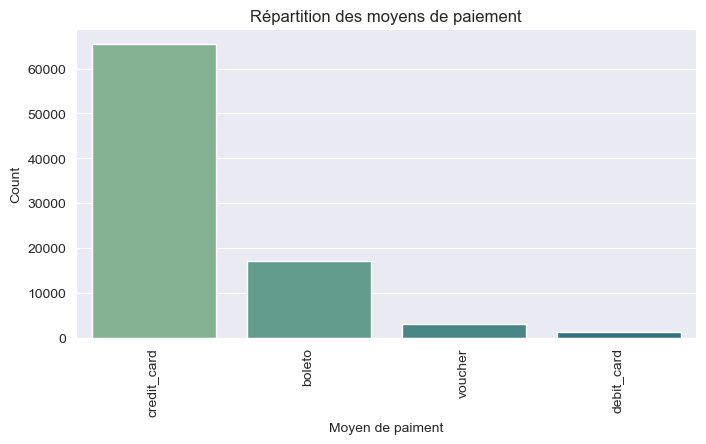

In [29]:
plt.figure(figsize=(8, 4))  # figure horizontale
palette = sns.color_palette('crest')  # palette de 10 couleurs différentes

sns.set_style("darkgrid")
sns.barplot(x=data_clients.type_paiement.value_counts().iloc[:10].index,
            y=data_clients.type_paiement.value_counts().iloc[:10],
            palette=palette)  # utilise la palette de couleurs définie
plt.xlabel("Moyen de paiment")
plt.ylabel("Count")
plt.title("Répartition des moyens de paiement")
plt.xticks(rotation=90)

sns.despine()  # enleve les bords superflus autour du graphique

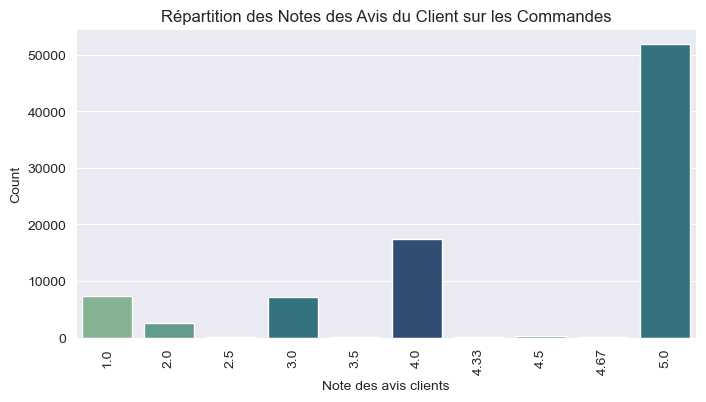

In [52]:
plt.figure(figsize=(8, 4))  # figure horizontale
palette = sns.color_palette('crest')  # palette de 10 couleurs différentes

sns.set_style("darkgrid")
sns.barplot(x=data_clients.score_moyen_review.value_counts().iloc[:10].index,
            y=data_clients.score_moyen_review.value_counts().iloc[:10],
            palette=palette)  # utilise la palette de couleurs définie
plt.xlabel("Note des avis clients")
plt.ylabel("Count")
plt.title("Répartition des Notes des Avis du Client sur les Commandes")
plt.xticks(rotation=90)

sns.despine()  # enleve les bords superflus autour du graphique

/Users/danongohou/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Orders Recency')

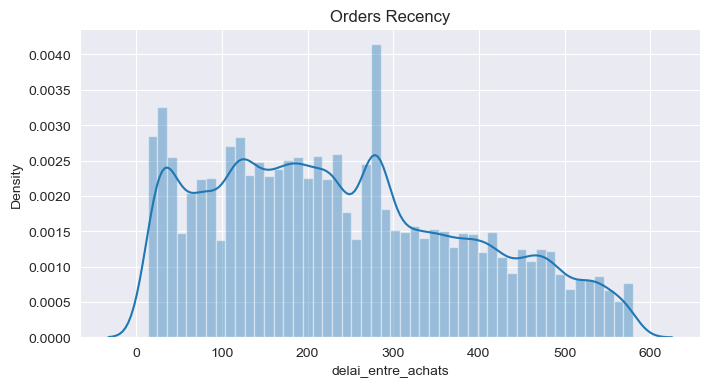

In [53]:
# Recence :
plt.figure(figsize=(8, 4))

sns.set_style("darkgrid")
ax = sns.distplot(data_clients['delai_entre_achats'])
ax.set_title("Orders Recency", fontsize=12)

/Users/danongohou/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Orders Frequency')

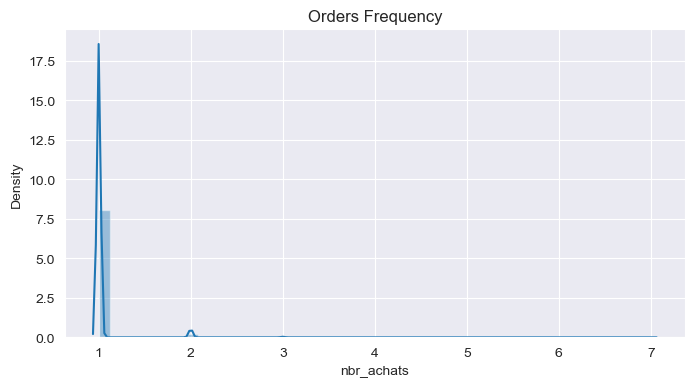

In [57]:
# Frequence :
plt.figure(figsize=(8, 4))

sns.set_style("darkgrid")
ax = sns.distplot(data_clients['nbr_achats'])
ax.set_title("Orders Frequency", fontsize=12)

/Users/danongohou/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Total spending')

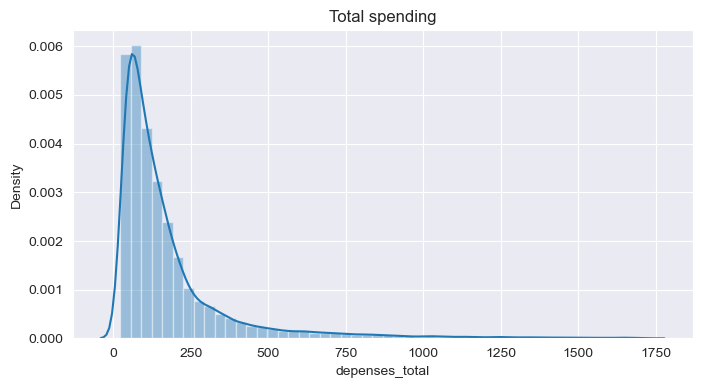

In [56]:
# Frequence :
plt.figure(figsize=(8, 4))
sns.set_style("darkgrid")
ax = sns.distplot(data_clients['depenses_total'])
ax.set_title("Total spending", fontsize=12)

# Analyse Multivariée :

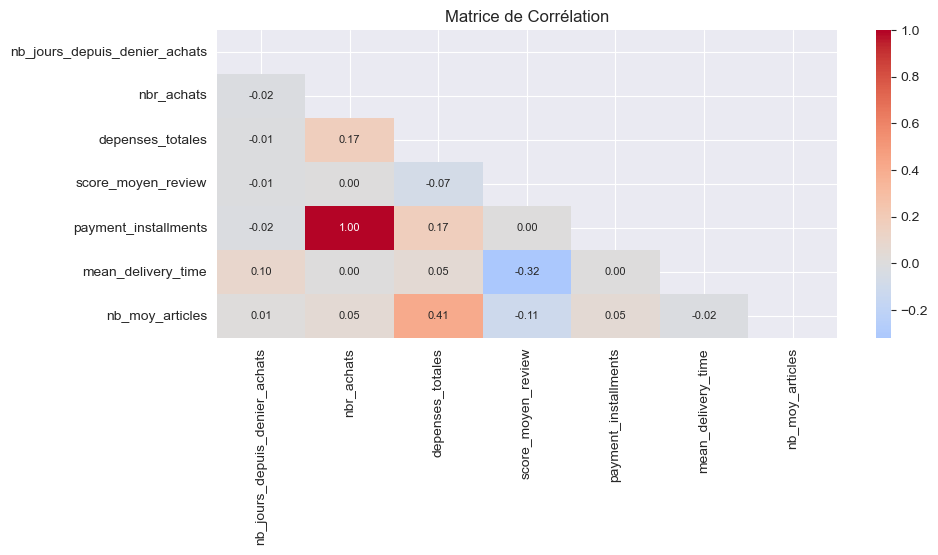

In [30]:
# Heatmap de Corrélation :

sns.set_style("whitegrid")
sns.set_style("darkgrid")
corr = data_clients.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size': 8},
                 mask=mask, center=0, cmap="coolwarm")
plt.title("Matrice de Corrélation")
plt.grid()
plt.show()

In [32]:
data_clients.drop(["payment_installments"], axis=1, inplace=True)

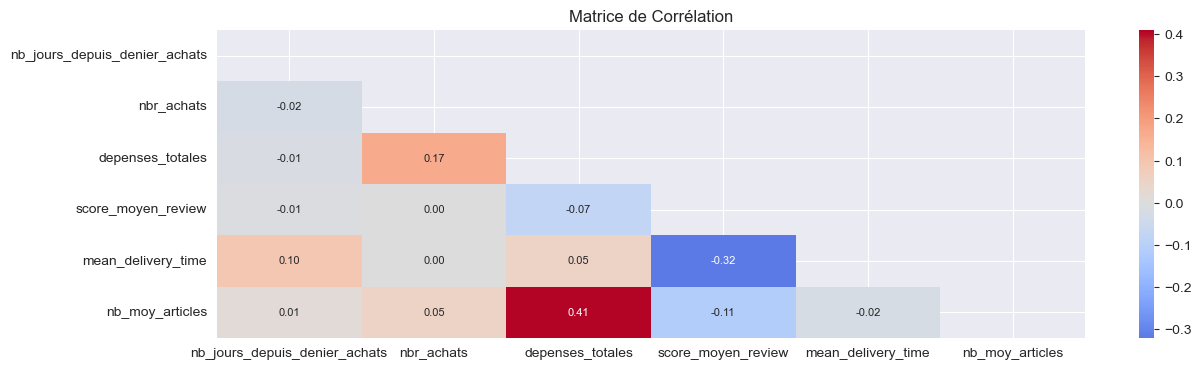

In [33]:
# Heatmap de Corrélation :

sns.set_style("whitegrid")
sns.set_style("darkgrid")
corr = data_clients.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(14, 4))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size': 8},
                 mask=mask, center=0, cmap="coolwarm")
plt.title("Matrice de Corrélation")
plt.grid()
plt.show()

In [83]:
data_clients.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 87115 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   nb_jours_depuis_denier_achats  87115 non-null  float64       
 1   nbr_achats                     87115 non-null  int64         
 2   depenses_total                 87115 non-null  float64       
 3   date_premier_achat             87115 non-null  datetime64[ns]
 4   date_dernier_achat             87115 non-null  datetime64[ns]
 5   score_moyen_review             87115 non-null  float64       
 6   type_paiement                  87115 non-null  object        
 7   customer_state                 87115 non-null  object        
 8   mean_delivery_time             87115 non-null  float64       
 9   nb_moy_articles                87115 non-null  float64       
dtypes: datetime64[ns](2), float64

In [84]:
data_clients.shape

(87115, 10)

In [85]:
data_clients.head(3) 

,nb_jours_depuis_denier_achats,nbr_achats,depenses_total,date_premier_achat,date_dernier_achat,score_moyen_review,type_paiement,customer_state,mean_delivery_time,nb_moy_articles
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116.0,1,141.90,2018-05-10,2018-05-10,5.0,credit_card,SP,6.0,1.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,27.19,2018-05-07,2018-05-07,4.0,credit_card,SP,3.0,1.0
0000f46a3911fa3c0805444483337064,542.0,1,86.22,2017-03-10,2017-03-10,3.0,credit_card,SC,26.0,1.0


# Sauvegarde du jeu de données nettoyé :

In [86]:
# Export des Données Nettoyées Datacore :

data_clients.to_csv('ESSAI_Dernier4.csv')